In [2]:
from dottamine import dotim
import numpy as np
import skimage as sk
import napari
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt

In [12]:
mask = sk.io.imread('domes/70_denoised_mask.tif').astype(np.uint8)

In [24]:
closed_mask = []
skelet_mnask = []
for i in mask:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((15, 15)))
    closed_mask.append(full)
    skelet_mnask.append(sk.morphology.skeletonize(full, method='lee'))
    

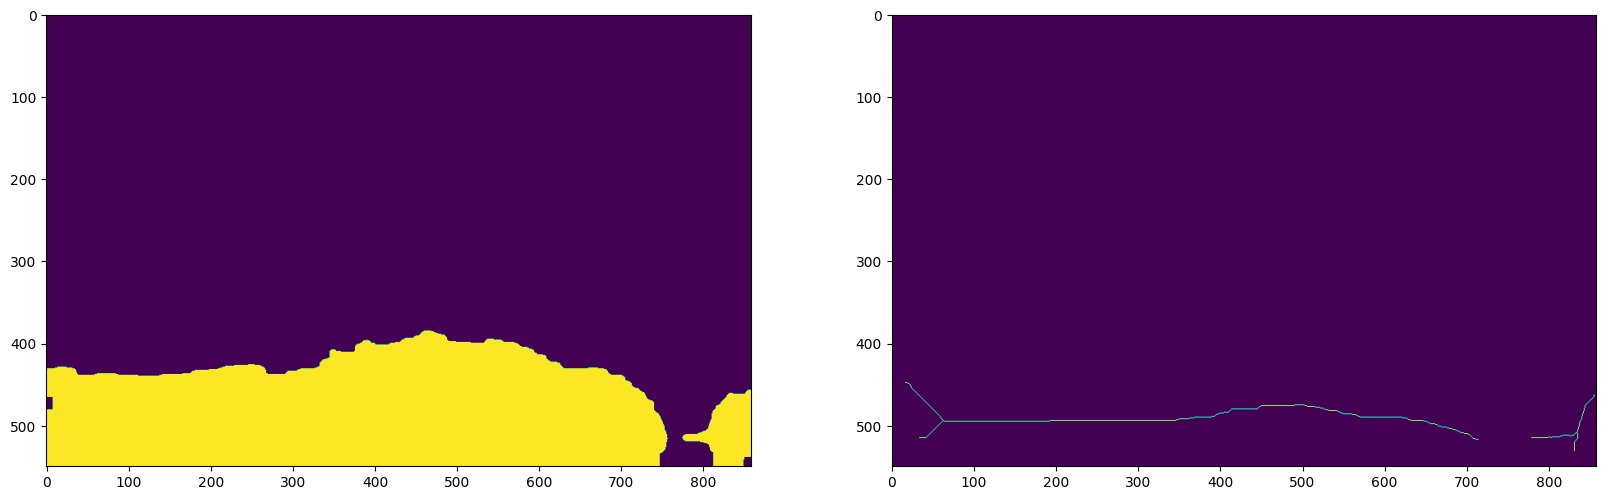

In [25]:
y = 100
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(closed_mask[y])
plt.subplot(122)
plt.imshow(skelet_mnask[y])